In [1]:
%matplotlib widget
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import pickle

Now we import wotan, a package used to remove instrumental and astrophysical signals through a filtering algorithm:

In [2]:
from wotan import flatten

In [4]:
sector44_dictionary = pickle.load(open('wasp12_tess_0044_selected.p', 'rb'))

In [5]:
time = sector44_dictionary['time']
sap_flux = sector44_dictionary['sap_flux']
sap_flux_error = sector44_dictionary['sap_flux_error']

In [6]:
transit_time = 2459501.137 # time at the center of the first transit
period = 1.09 # transit period (in days) 
transit_duration = 3.05 / 24. # transit duration (in days)

Now we fit the sap_flux data with a curve (sap_flatten_model) and we also normalize the sap_flux (sap_flatten_flux):

In [8]:
sap_flatten_flux, sap_flatten_model = flatten(
    time,                   # Array of time values
    sap_flux,               # Array of flux values
    method='hspline',
    window_length=1.1,      # The knot distance in units of ``time``
    break_tolerance=0.5,    # Split into segments at breaks longer than that
    return_trend = True     # Return trend and flattened light curve
)

Now we can plot the sap_flux vs time and the fit (sap_flatten_model):

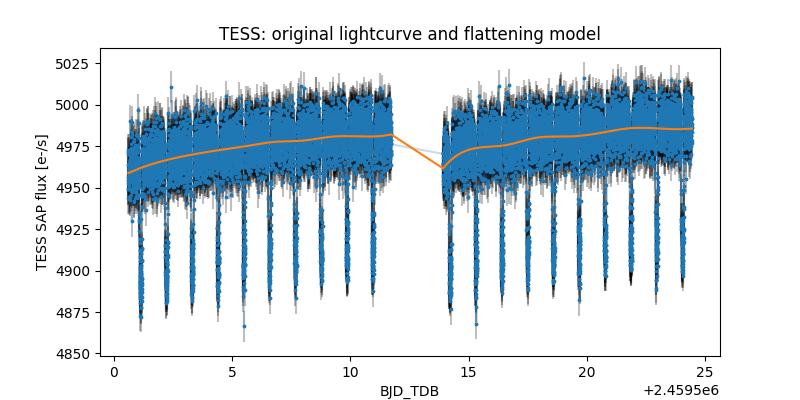

In [9]:
plt.figure(figsize=(8,4))
plt.title('TESS: original lightcurve and flattening model')
plt.scatter(time, sap_flux, c='C0', s=3)
plt.errorbar(time, sap_flux, yerr=sap_flux_error, ecolor='k', fmt='', alpha=0.25, zorder=-1)
plt.plot(time, sap_flatten_model, c='C1', zorder=10)
plt.xlabel('BJD_TDB')
plt.ylabel('TESS SAP flux [e-/s]')
plt.show()

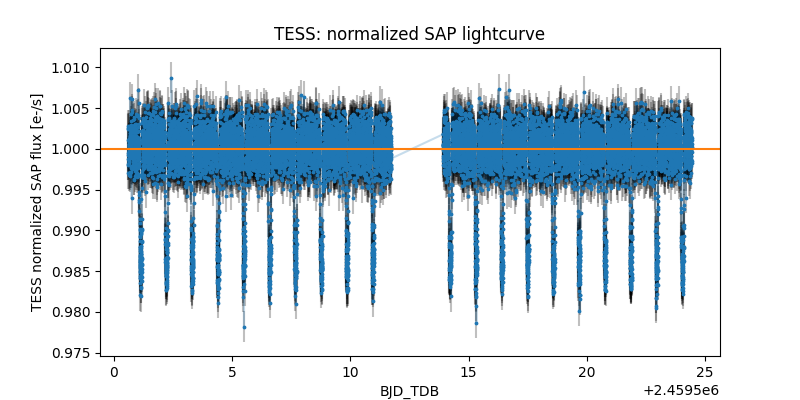

In [10]:
# here we plot the normalized flux:
plt.figure(figsize=(8,4))
plt.title('TESS: normalized SAP lightcurve')
plt.scatter(time, sap_flatten_flux, c='C0', s=3)
plt.errorbar(time, sap_flatten_flux, yerr=sap_flux_error/sap_flatten_model, ecolor='k', fmt='', alpha=0.25, zorder=-1)
plt.axhline(1, c='C1')
plt.xlabel('BJD_TDB')
plt.ylabel('TESS normalized SAP flux [e-/s]')
plt.show()

Let's focus on the filtering algorithm's results near the transits. To better visualize the results, we can fold the transit around the central time of transits, knowing that the same signal is supposed to repeat after every orbital period. After folding the transit, we can focus on the small portion of time around it rather than display the entire orbital period.

In [11]:
phase_folded_time = (time-transit_time-period/2)%period - period/2
print (time, phase_folded_time)

[2459500.60069556 2459500.60208458 2459500.60347361 ... 2459524.44030299
 2459524.44169198 2459524.44308096] [-0.53630444 -0.53491542 -0.53352639 ...  0.41330299  0.41469198
  0.41608096]


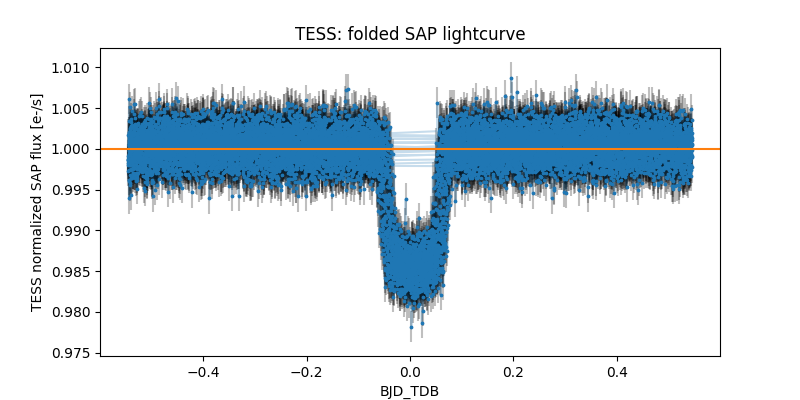

In [12]:
plt.figure(figsize=(8,4))
plt.title('TESS: folded SAP lightcurve')
plt.scatter(phase_folded_time, sap_flatten_flux, c='C0', s=3)
plt.errorbar(phase_folded_time, sap_flatten_flux, yerr=sap_flux_error/sap_flatten_model, ecolor='k', fmt='', alpha=0.25, zorder=-1)
plt.axhline(1, c='C1')
plt.xlabel('BJD_TDB')
plt.ylabel('TESS normalized SAP flux [e-/s]')
plt.show()

Actually we made the fit and the normalization including the transits. Now we make a MASK to exclude the transit and do again the fit and the normalization:

In [13]:
from wotan import transit_mask
transit_window = transit_duration * 2

mask = transit_mask(
    time=time,
    period=period,
    duration=transit_window,
    T0=transit_time
)

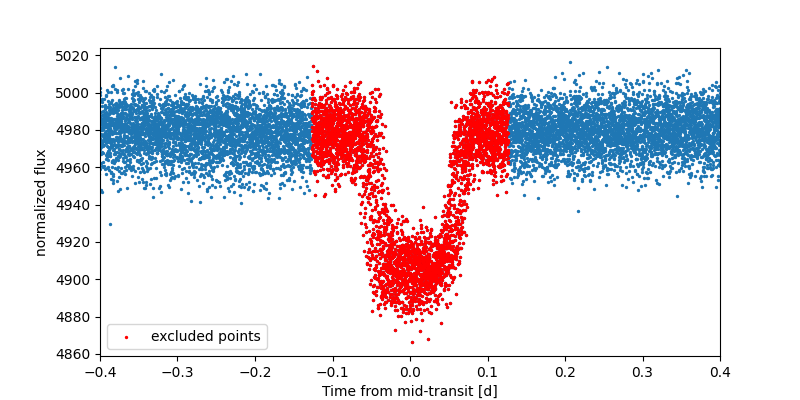

In [14]:
plt.figure(figsize=(8,4))
plt.scatter(phase_folded_time, sap_flux, s=2)
plt.scatter(phase_folded_time[mask], sap_flux[mask], c='r', zorder=1, s=2, label='excluded points')
plt.xlabel('Time from mid-transit [d]')
plt.ylabel('normalized flux')
plt.xlim(-0.4, 0.4)
plt.legend()
plt.show()

In [15]:
sap_masked_flatten_flux, sap_masked_flatten_model = flatten(
    time,
    sap_flux,
    method='hspline',
    window_length=1.1,
    break_tolerance=0.5,
    return_trend=True,
    mask=mask)

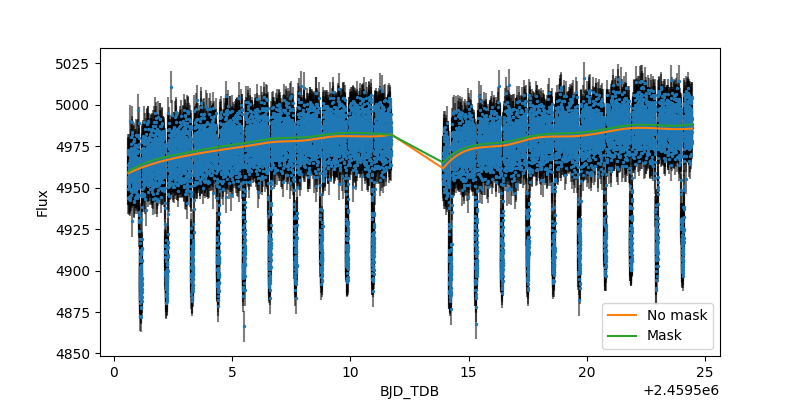

In [16]:
# here we plot agan the flux and the two fit curves (masked and not masked):
plt.figure(figsize=(8,4))
plt.scatter(time, sap_flux, c='C0', s=2)
plt.errorbar(time, sap_flux, yerr=sap_flux_error, ecolor='k', fmt=' ', alpha=0.5, zorder=-1)
plt.plot(time, sap_flatten_model, c='C1', zorder=10, label='No mask')
plt.plot(time, sap_masked_flatten_model, c='C2', zorder=11, label='Mask')
plt.xlabel('BJD_TDB')
plt.ylabel('Flux')
plt.legend()
plt.show()

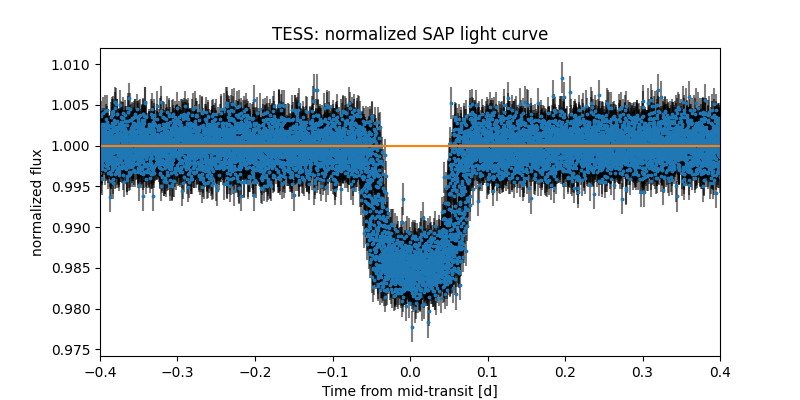

In [17]:
plt.figure(figsize=(8,4))
plt.title('TESS: normalized SAP light curve')
plt.scatter(phase_folded_time, sap_masked_flatten_flux, c='C0', s=3)
plt.errorbar(phase_folded_time, sap_masked_flatten_flux, yerr=sap_flux_error/sap_flatten_model, 
             ecolor='k', fmt=' ', alpha=0.5, zorder=-1)
plt.xlabel('Time from mid-transit [d]')
plt.ylabel('normalized flux')
plt.xlim(-0.4, 0.4)
plt.axhline(1.000, c='C1')
plt.show()

In [18]:
print('STD with mask : {0:.6f}'.format(np.std(sap_masked_flatten_flux[np.logical_not(mask)])))
print('STD without mask : {0:.6f}'.format(np.std(sap_flatten_flux[np.logical_not(mask)])))
print('Median error of flattened flux (masked): {0:.8f}'.format(np.median(sap_flux_error/sap_masked_flatten_model)))
print('Median error of flattened flux (not masked): {0:.8f}'.format(np.median(sap_flux_error/sap_flatten_model)))

STD with mask : 0.001878
STD without mask : 0.001880
Median error of flattened flux (masked): 0.00190027
Median error of flattened flux (not masked): 0.00190101


We now do the same exercise with PDCSAP:

In [19]:
pdcsap_flux =  sector44_dictionary['pdcsap_flux']
pdcsap_flux_error = sector44_dictionary['pdcsap_flux_error']

pdcsap_masked_flatten_flux, pdcsap_masked_flatten_model = flatten(
    time,
    sap_flux,
    method='hspline',
    window_length=1.1, 
    break_tolerance=0.5, 
    return_trend = True,
    mask = mask,
)

In [20]:
print('PDC STD with mask : {0:.6f}'.format(np.std(pdcsap_masked_flatten_flux[np.logical_not(mask)])))
print('PDC Median error of flattened flux (masked): {0:.8f}'.format(np.median(pdcsap_flux_error/pdcsap_masked_flatten_model)))

PDC STD with mask : 0.001878
PDC Median error of flattened flux (masked): 0.00190027


In [21]:
flatten_sector44_dictionary = {
    'time':time,
    'sap_masked_hspline_w11_flux':sap_masked_flatten_flux,
    'sap_masked_hspline_w11_flux_error':sap_flux_error/sap_masked_flatten_model,
    'pdcsap_masked_hspline_w11_flux':pdcsap_masked_flatten_flux,
    'pdcsap_masked_hspline_w11_flux_error':pdcsap_flux_error/pdcsap_masked_flatten_model
}
pickle.dump(flatten_sector44_dictionary, open('WASP-12_TESS_sector044_selected.p','wb'))